In [2]:
from src.utils import *
import src.utils as utils
from src.analysis import *
import src.analysis as analysis
import importlib
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
importlib.reload(utils)
importlib.reload(analysis)
import plotly.express as px
import collections
from sklearn.utils import resample


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error


In [3]:
dataset = pd.read_csv('data/dataset_final.csv')

## Research Question 1: What traits in books make them attractive for adaptation?


In [4]:
movie_adaptation = dataset[dataset['movie_is_adaptation'] == 1]

In [5]:
movie_adaptation.columns

Index(['Unnamed: 0', 'movie_title', 'movie_release', 'movie_revenue',
       'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres',
       'movie_wikidata_id', 'imdb_rating', 'imdb_total_votes', 'movie_budget',
       'book_wikidata_id', 'book_title', 'book_author', 'book_release',
       'book_country', 'book_part_of_series', 'literary_work', 'written_work',
       'comic_book_seris', 'book_series', 'manga_series', 'book_fiction',
       'book_non_fiction', 'book_children', 'book_historical', 'book_drama',
       'book_anime', 'book_fantasy', 'book_science_fiction', 'book_horror',
       'book_thriller', 'book_detective', 'book_satire', 'book_comedy',
       'book_won_price', 'book_rating', 'book_publisher', 'book_ratings_count',
       'book_pages', 'movie_is_adaptation', 'time_gap', 'revenue_budget_ratio',
       'movie_revenue_log', 'movie_budget_log'],
      dtype='object')

### Book pages and ratings

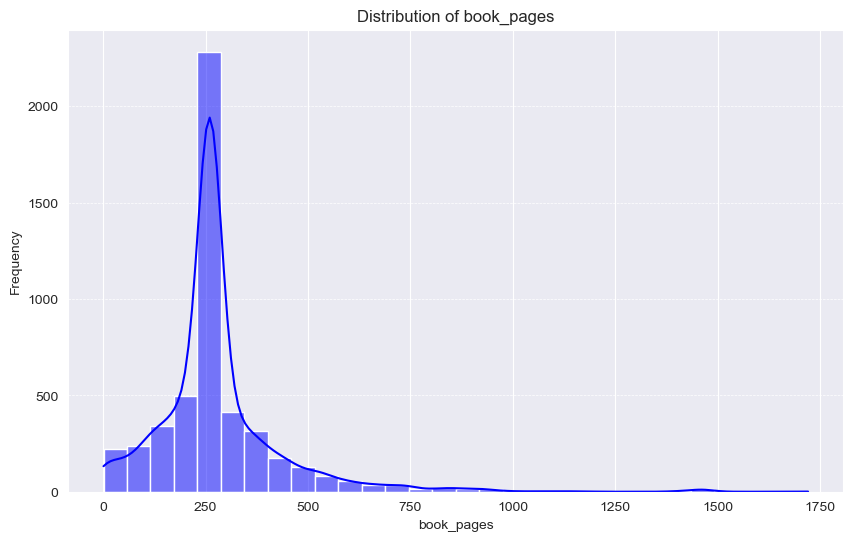

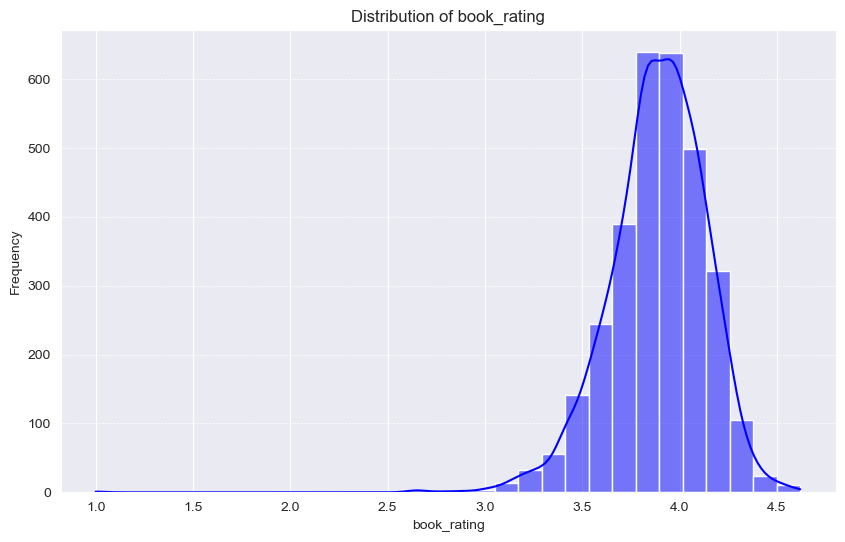

In [6]:
plot_histograms(movie_adaptation, ['book_pages', 'book_rating'])

We can see that most adaptations are of books of approximately 250 pages, and of ratings > 3.75.

### Book genres

/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index.str.replace('book_', '').str.replace('_', ' ').str.title(),


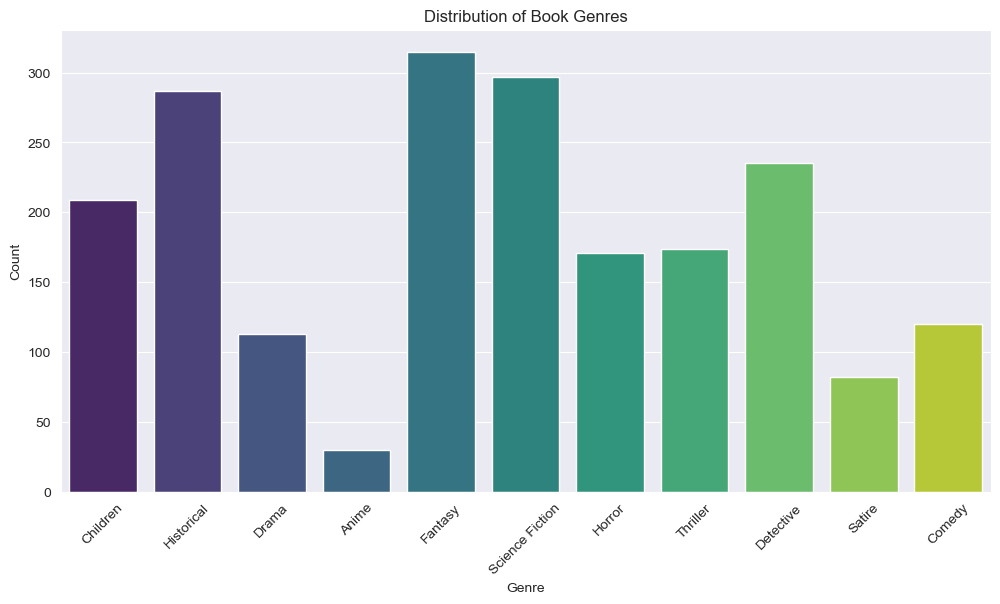

In [7]:
histogram_book_genre(movie_adaptation)

We can see that the genres that are attractive for adaptation are mostly historical, fantasy, science-fiction and detective.

### Fiction or not

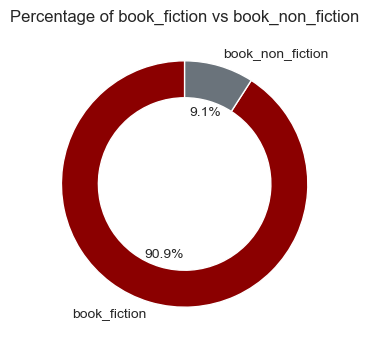

In [8]:
plot_pie_chart_2(movie_adaptation, 'book_fiction', 'book_non_fiction')

Most of the books that are adapted are fictions.

### Book part of a serie or not

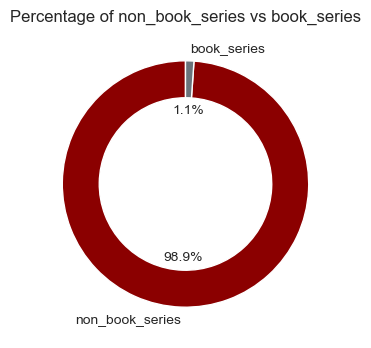

In [9]:
plot_pie_chart_1(movie_adaptation, 'book_series')

Most of the books that are adapted are not part of a serie.

Most of the books that are adapted are not part of a serie.


In the first section of our analysis, we observed what are the most important features of our adaptation set. As a Hollywood executive considering adapting a book for our next production, an important question arises: Which book should we adapt? To address this, we will analyze books that have been adapted in the past, aiming to predict which non-adapted ones might be suitable for future adaptations.

To proceed, we will merge the books from the adaptation_df (those that have already been adapted) with those from the book_df (those not yet adapted). For our analyses, we will focus solely on books for which we have data from Wikimedia as well as Goodreads ratings.

In [10]:
book_df = pd.read_csv('data/book.csv')

### Publicaion date of adapted books

In [11]:
# Select book-related columns from the adaptation dataset and filter out entries wiith missing book-data.
book_cols = [col for col in dataset.columns if col.startswith('book_')]

adapted_book_df = (dataset
                   .query('movie_is_adaptation == 1 & book_rating.notna()')
                   .assign(book_adapted = 1)
                   .loc[:, book_cols + ['book_adapted']]
                   .reset_index(drop=True)
                   )

# Make sure that we do not consider books that have an adaptation in the book_df
adapted_wikidata_ids = adapted_book_df['book_wikidata_id'].unique()

book_df = (book_df
           .query('book_wikidata_id not in @adapted_wikidata_ids')
           .assign(book_adapted = 0)
           .loc[:, book_cols + ['book_adapted']]
           .reset_index(drop=True)
           )

adapted_book_df = pd.concat([book_df, adapted_book_df], axis=0).reset_index(drop=True).assign(
        label=lambda x: x.book_adapted.map({1: "Adapted", 0: "Not-Adapted"}).astype("category").cat.reorder_categories(["Not-Adapted", "Adapted"], ordered=True))
    

fiction_cols = adapted_book_df.columns[7:9].tolist()
genre_cols = adapted_book_df.columns[9:20].tolist()

/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:269: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='label', ax=ax0, palette=['#6a737b', '#8B0000'], fliersize=0)


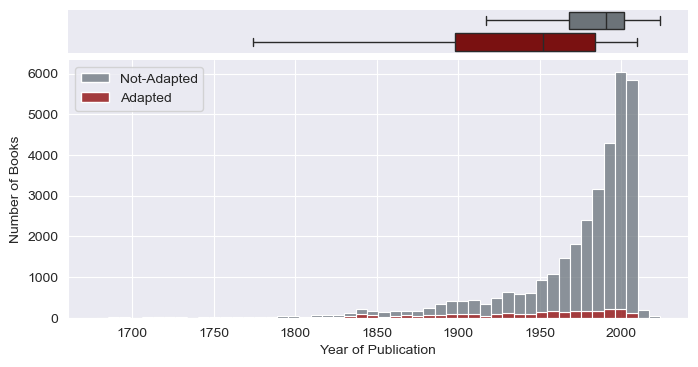

The p-value of the t-test is 0.000e+00.
The average adapted books is 40.00 years older than the average non-adapted book.


In [12]:
make_book_histplot(df=adapted_book_df, col='book_release', x_label='Year of Publication')

# Compute the t-test
test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_release.notna()').book_release,
                        adapted_book_df.query('book_adapted == 0 & book_release.notna()').book_release)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = adapted_book_df.query('book_adapted == 1').book_release.mean() - adapted_book_df.query('book_adapted == 0').book_release.mean()
print(f'The average adapted books is {-diff_means:.2f} years older than the average non-adapted book.')

From the plot, it is clear that books chosen for adaptation tend to be older. One possible reason for this could be that Hollywood executives often favor classics that have already proven their enduring popularity over time.

The difference between the distributions of adapted and non-adapted books may also be influenced by production dynamics. Movie production is constrained by the resources available during any given period, whereas book publication has accelerated significantly due to the democratization and growing accessibility of writing, particularly after 1990.

Another key factor is the lag time between a book's publication and its adaptation into a film. Even if work on an adaptation began immediately upon a book's release—an unlikely scenario—it would still take several years to complete. As a result, many books published between 2000 and 2010 may still be in the pipeline for adaptation, which could explain the observed decline in adaptations for books published after 2000.

### Ratings of adapated books

Another important question to address is whether filmmakers tend to adapt higher-quality books. To explore this, we will analyze the Goodreads ratings of the books. However, we need to account for potential confounding variables that could skew our results:

Publication year: As discussed in previous section, adapted books are typically older. Older books may have higher ratings in our dataset because lower-quality books from those periods might not be listed on Goodreads. This factor needs careful consideration.
Genre: Certain genres may be more likely to be adapted into films. If rating differences exist across genres, they could impact our analysis.
To address these potential biases, we will apply exact matching. For the publication year, we will group books into 5-year intervals. Additionally, we will only include books with at least 10 ratings to ensure the average rating is reasonably reliable.

In [13]:
balanced_df = matching_books(adapted_book_df, fiction_cols, genre_cols)

Building Graph: 100%|██████████| 2300312/2300312 [00:30<00:00, 76479.36it/s]


/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='label', ax=ax0, palette=['#6a737b', '#8B0000'], fliersize=0)


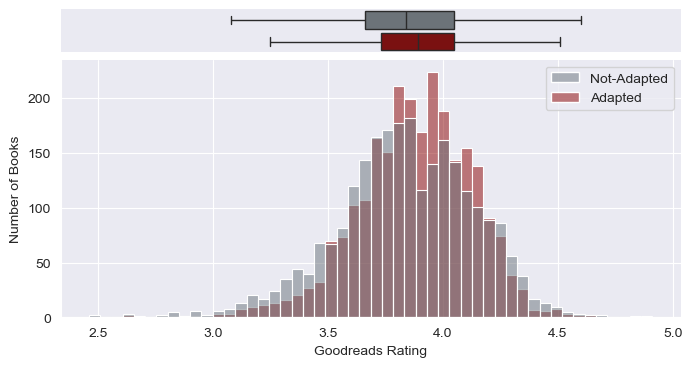

The p-value of the t-test is 2.100e-07.
The mean rating of adapted book is 0.04 higher than that of not-adapted books.


In [14]:
make_book_histplot_2(df=balanced_df, col='book_rating', x_label='Goodreads Rating')

# Compute the t-test
test_result = ttest_ind(balanced_df.query('book_adapted == 1 & book_rating.notna()').book_rating,
                        balanced_df.query('book_adapted == 0 & book_rating.notna()').book_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = balanced_df.query('book_adapted == 1').book_rating.mean() - balanced_df.query('book_adapted == 0').book_rating.mean()
print(f'The mean rating of adapted book is {diff_means:.2f} higher than that of not-adapted books.')

We have observed a statistically significant difference at the 5% level. However, the average Goodreads rating for an adapted book is only 0.05 points higher than that of a non-adapted book.

### Number of pages of adapted books

/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='label', ax=ax0, palette=['#6a737b', '#8B0000'], fliersize=0)


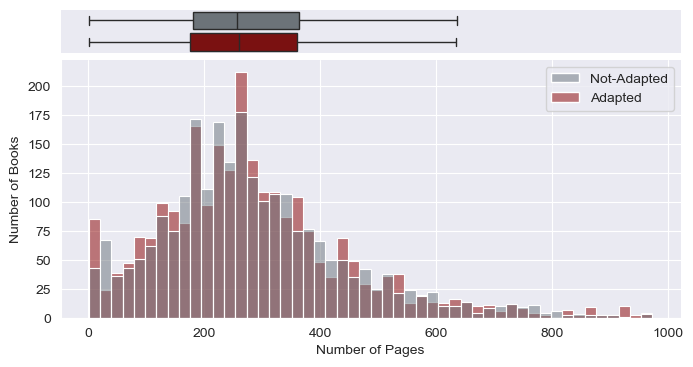

The p-value of the t-test is 0.871.
The average adapted book has -0.87 more pages than the average not-adapted book.


In [15]:
make_book_histplot_2(df=balanced_df.query('book_pages < 1000'), col='book_pages', x_label='Number of Pages')

# Compute the t-test
test_result = ttest_ind(balanced_df.query('book_adapted == 1 & book_pages.notna()').book_pages,
                        balanced_df.query('book_adapted == 0 & book_pages.notna()').book_pages)
print(f'The p-value of the t-test is {test_result.pvalue:.3f}.')

# Compute the difference in means
diff_means = balanced_df.query('book_adapted == 1').book_pages.mean() - balanced_df.query('book_adapted == 0').book_pages.mean()
print(f'The average adapted book has {diff_means:.2f} more pages than the average not-adapted book.')

For number of pages we could not find significant differences (at a 5% level) between adapted and non-adapted books.

### Number of ratings of adapted books

/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log"] = np.log(df[col])
/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="log", y='label', ax=ax0, palette=['#6a737b', '#8B0000'], fliersize=0)


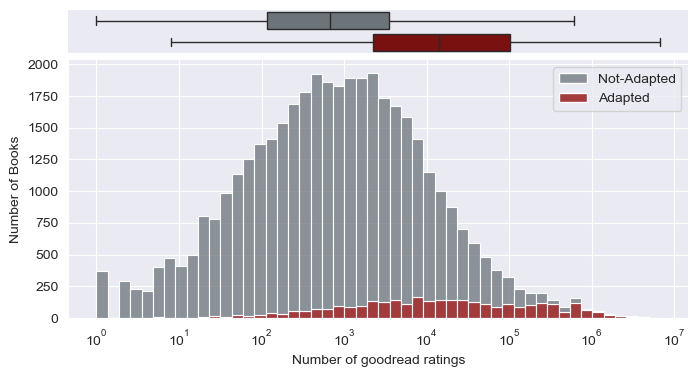

The p-value of the t-test is 0.000e+00.
The average adapted book has 148448.43 more ratings than the average not-adapted book.


In [16]:
make_book_histplot(df=adapted_book_df.query("book_ratings_count > 0"), col='book_ratings_count', x_label='Number of goodread ratings', log=True)

# Compute the t-test
test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_ratings_count.notna()').book_ratings_count,
                        adapted_book_df.query('book_adapted == 0 & book_ratings_count.notna()').book_ratings_count)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = adapted_book_df.query('book_adapted == 1').book_ratings_count.mean() - adapted_book_df.query('book_adapted == 0').book_ratings_count.mean()
print(f'The average adapted book has {diff_means:.2f} more ratings than the average not-adapted book.')

As expected, adapted books are more popular than non-adapted ones, as evidenced by the higher number of ratings on Goodreads. This result is statistically significant at the 5% level. However, interpreting this finding requires caution due to a potential feedback loop in the data. Specifically, Goodreads data might have been updated after a movie’s release, as people are likely to read a book after watching its adaptation. This could inflate the number of Goodreads ratings, introducing target leakage into our analysis.

### Adapted book won price ?

Now, let's compare adapted and non-adapted books in terms of whether they are critically acclaimed. To account for differences in genre and publication date, we will use the matched dataframe.

/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_91774/1801345163.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=balanced_df, y='label', x='book_won_price_pct', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax)


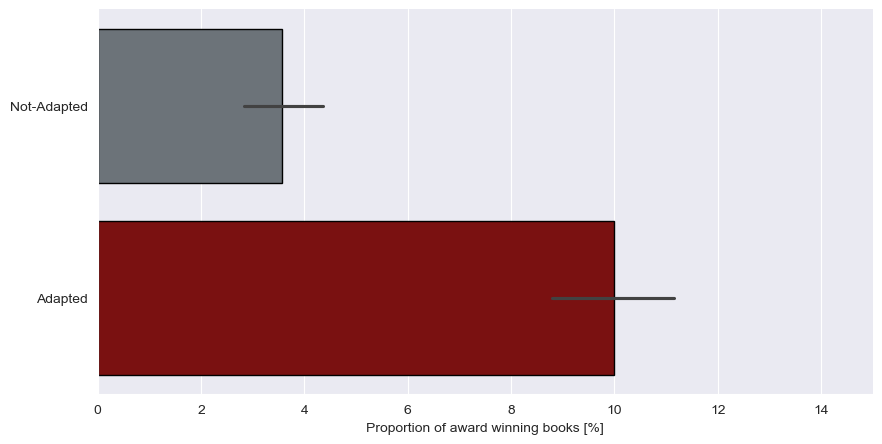

In [17]:
balanced_df['book_won_price_pct'] = balanced_df['book_won_price'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=balanced_df, y='label', x='book_won_price_pct', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax)
plt.xlabel('Proportion of award winning books [%]')
plt.ylabel('')

plt.xlim(0,15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

There is a clear difference between adapted and non-adapted books when it comes to awards won. The non-overlapping 95% confidence intervals for the means indicate that this result is statistically significant. This supports our assumption that Hollywood executives often choose to adapt classic, award-winning books into movies.

## Research Question 2: How long does it take for a popular book to become a movie, and what influences this timeline? (RANIA)

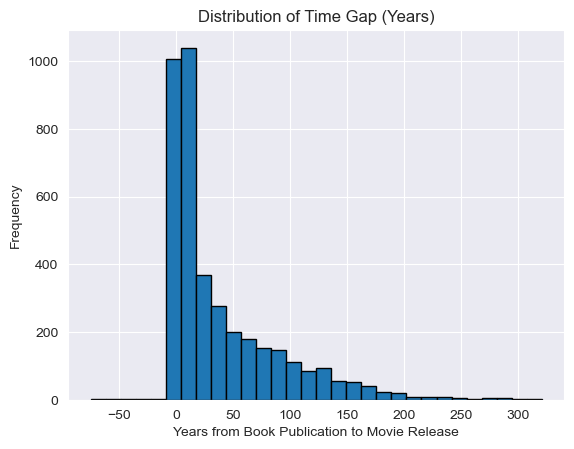

In [18]:
# Exploring the time_gap variable
movie_adaptation['time_gap'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Time Gap (Years)')
plt.xlabel('Years from Book Publication to Movie Release')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Handling NaN values of timegap column

movie_adaptation['time_gap'] = movie_adaptation['time_gap'].fillna(movie_adaptation['time_gap'].median())


/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_91774/1152408133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_adaptation['time_gap'] = movie_adaptation['time_gap'].fillna(movie_adaptation['time_gap'].median())


In [20]:
import lifelines
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator
kmf.fit(movie_adaptation['time_gap'], event_observed=[1] * len(movie_adaptation))

# Plot the survival curve
kmf.plot_survival_function()
plt.title('Survival Curve for Book-to-Movie Adaptations')
plt.xlabel('Years from Book Publication to Movie Release')
plt.ylabel('Survival Probability')
plt.xlim([0,300])
plt.show()


ModuleNotFoundError: No module named 'lifelines'

In [21]:
# Group by book_won_price
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for group, subset in movie_adaptation.groupby('book_won_price'):
    kmf.fit(subset['time_gap'], event_observed=[1] * len(subset), label=f"Prize: {group}")
    kmf.plot_survival_function()

plt.title('Survival Curves by Book Prize Status')
plt.xlabel('Years from Book Publication to Movie Release')
plt.xlim([0,300])
plt.ylabel('Survival Probability')
plt.legend(title='Book Won Prize')
plt.show()


NameError: name 'KaplanMeierFitter' is not defined

In [22]:
from lifelines.statistics import logrank_test

group1 = movie_adaptation[movie_adaptation['book_won_price'] == 1]['time_gap']
group2 = movie_adaptation[movie_adaptation['book_won_price'] == 0]['time_gap']

results = logrank_test(group1, group2)
print("Log-Rank Test p-value:", results.p_value)


ModuleNotFoundError: No module named 'lifelines'

## Research Question 4: What elements predict the success of a movie adaptation?

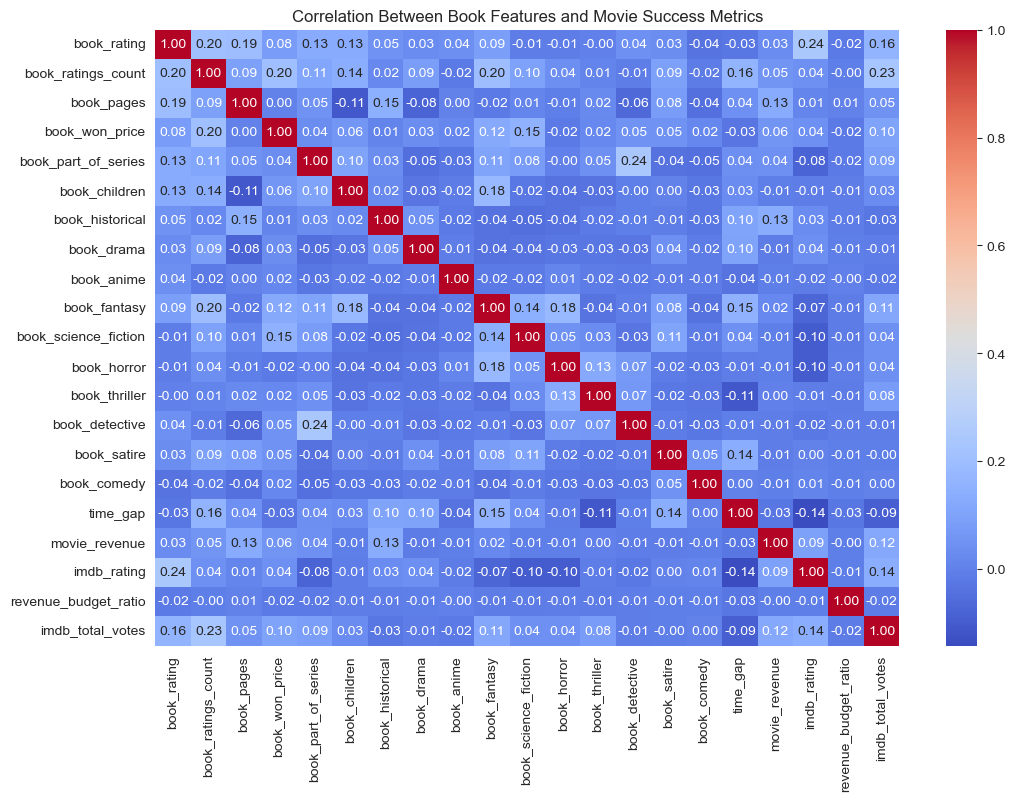

In [23]:
# Select relevant features
book_features = ['book_rating', 'book_ratings_count', 'book_pages', 'book_won_price',
                 'book_part_of_series', 'book_children', 'book_historical', 'book_drama',  'book_anime', 'book_fantasy', 'book_science_fiction', 'book_horror',
                 'book_thriller', 'book_detective', 'book_satire', 'book_comedy', 'time_gap']
movie_metrics = ['movie_revenue', 'imdb_rating', 'revenue_budget_ratio', 'imdb_total_votes']

# Correlation matrix
correlation_matrix = dataset[book_features + movie_metrics].corr()

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Book Features and Movie Success Metrics')
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

auxiliary_dataset = pd.read_csv('data/auxiliary_dataset.csv')

# Prepare data
X = auxiliary_dataset[book_features]
y = auxiliary_dataset['movie_revenue']  # Or other success metric
data = pd.concat([X, y], axis=1)
data_clean = data.dropna()

X = data_clean[X.columns]
y = data_clean[y.name]
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
print("R^2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R^2 Score: -0.37948059641841003
Mean Squared Error: 4.17553886251455e+18


In [25]:
from scipy.stats import ttest_ind

# Separate groups
adapted = dataset[dataset['movie_is_adaptation'] == 1]
original = dataset[dataset['movie_is_adaptation'] == 0]

# Compare revenue
t_stat, p_value = ttest_ind(adapted['movie_revenue'], original['movie_revenue'], nan_policy='omit')
print("T-test for Revenue: t-stat =", t_stat, ", p-value =", p_value)

# Compare IMDb ratings
t_stat, p_value = ttest_ind(adapted['imdb_rating'], original['imdb_rating'], nan_policy='omit')
print("T-test for IMDb Ratings: t-stat =", t_stat, ", p-value =", p_value)

T-test for Revenue: t-stat = 5.288409385374912 , p-value = 1.2584770562314077e-07
T-test for IMDb Ratings: t-stat = 22.6997566762327 , p-value = 1.2864133103689105e-113


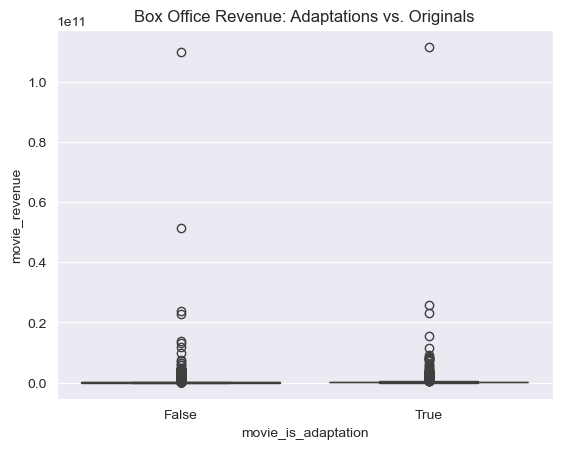

In [26]:
sns.boxplot(x='movie_is_adaptation', y='movie_revenue', data=dataset)
plt.title('Box Office Revenue: Adaptations vs. Originals')
plt.show()

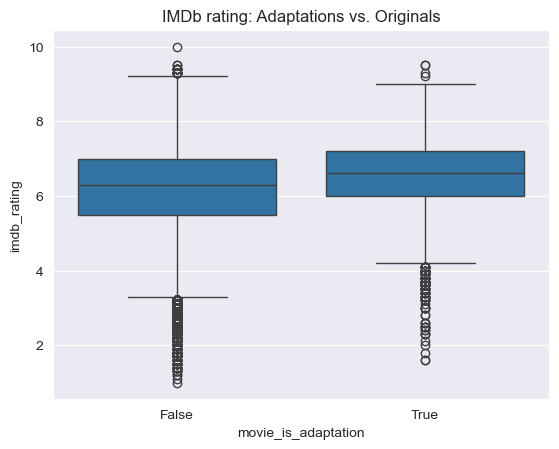

In [27]:
sns.boxplot(x='movie_is_adaptation', y='imdb_rating', data=dataset)
plt.title('IMDb rating: Adaptations vs. Originals')
plt.show()

### Do movies based on books perform better at the box office?

Potential Confounding Variables
Genre: Certain genres, such as fantasy, may be more commonly adapted from books. If these genres naturally tend to perform better at the box office, the success of such movies might not be entirely due to their status as adaptations.
Temporal Trends: The prevalence of book adaptations and the overall success of cinema have changed over time. These temporal shifts could influence the analysis.
Budget: Movies based on books might typically have higher budgets, which could inherently result in greater box office success.
Country: In some countries, such as India (with Bollywood), book adaptations may be less common, and the box office performance of films might follow different trends.
Movie Runtime: The length of a movie could affect ticket prices, thereby influencing its box office revenue

Solution: matching with propensity score !

In [28]:
balanced_df_rev = matching_revenues(dataset)

Building Graph: 100%|██████████| 4552/4552 [00:59<00:00, 76.60it/s]


/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


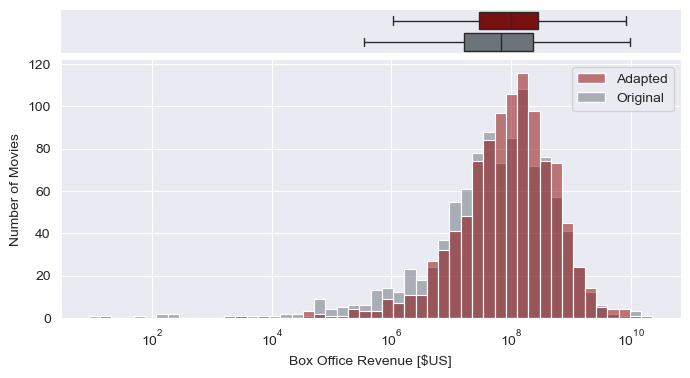

In [29]:
plot_revenue_histogram(balanced_df_rev)

In [30]:
import statsmodels.formula.api as smf
test_result = ttest_ind(balanced_df_rev.query('movie_is_adaptation').movie_revenue_log,
                        balanced_df_rev.query('~movie_is_adaptation').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue}')

model = smf.ols('movie_revenue_log ~ movie_is_adaptation', data=balanced_df_rev)
results = model.fit()
slope = results.params[1]
print(f'Book Adaptation Impact on Rating: {slope:.2f}')

The p-value of the t-test is 4.164237975659403e-07
Book Adaptation Impact on Rating: 0.22


/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_91774/3322626776.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]


In [31]:
balanced_df_rat = matching_rating(dataset)

Building Graph: 100%|██████████| 42733/42733 [00:00<00:00, 64292.42it/s]


/Users/ghaliabennani/Desktop/MA3/ADA/ada-2024-project-ada212/src/analysis.py:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


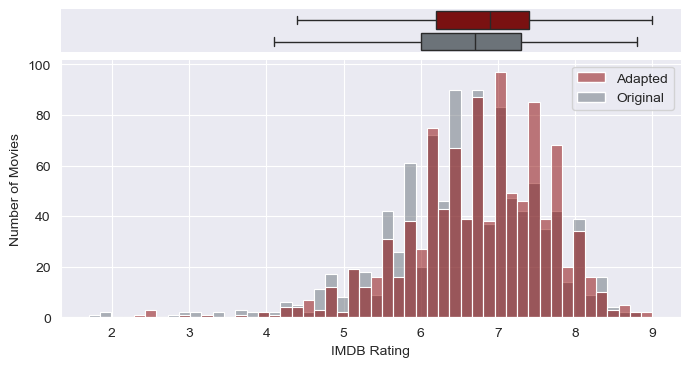

In [32]:
plot_ratings_histogram(balanced_df_rat)

In [33]:
test_result = ttest_ind(balanced_df_rat.query('movie_is_adaptation').imdb_rating,
                        balanced_df_rat.query('~movie_is_adaptation').imdb_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}')

model = smf.ols('imdb_rating ~ movie_is_adaptation', data=balanced_df_rat)
results = model.fit()
slope = results.params[1]
print(f'Book Adaptation Impact on Rating: {slope:.2f}')

The p-value of the t-test is 3.509e-05
Book Adaptation Impact on Rating: 0.18


/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_91774/325434888.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]


## Research Question 5: How has the popularity and financial success of book adaptations evolved over time?

In [34]:
dataset['release_decade'] = (auxiliary_dataset['movie_release'] // 10) * 10
decade_group = dataset.groupby('release_decade')

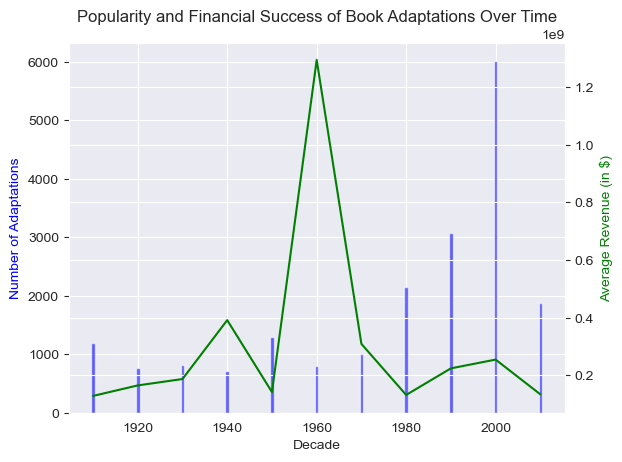

In [35]:
popularity = decade_group.size()  # Count of adaptations
avg_revenue = decade_group['movie_revenue'].mean()
total_revenue = decade_group['movie_revenue'].sum()

fig, ax1 = plt.subplots()

ax1.bar(popularity.index, popularity.values, color='blue', alpha=0.6, label="Number of Adaptations")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Number of Adaptations", color='blue')

ax2 = ax1.twinx()
ax2.plot(avg_revenue.index, avg_revenue.values, color='green', label="Average Revenue")
ax2.set_ylabel("Average Revenue (in $)", color='green')

plt.title("Popularity and Financial Success of Book Adaptations Over Time")
plt.show()

## Research Question 6: How do movie adaptations perform internationally, and are adaptations from certain countries more successful?

In [43]:

# Filter adaptations
adaptations = dataset[dataset['movie_is_adaptation'] == True]
adaptations = adaptations[adaptations['movie_revenue'].notna()]

# Aggregate revenue by country
revenue_by_country = adaptations.groupby('movie_countries')['movie_revenue'].sum().reset_index()

# Set a lower range limit to compress the color scale
min_revenue = 1  # Start from 1 to avoid white (logarithmic adjustment)
max_revenue = revenue_by_country['movie_revenue'].quantile(0.99)  # Use 95th percentile to avoid extreme outliers

# Define the color map with adjusted range
fig = px.choropleth(
    revenue_by_country,
    locations='movie_countries',
    locationmode='country names',
    color='movie_revenue',
    title='Revenue of Movie Adaptations by Country',
    color_continuous_scale=['#fee5d9', '#de2d26'],  # Monochromatic light-to-dark blue
    range_color=(min_revenue, max_revenue)  # Compress range to enhance visualization
)
# Display the figure
fig.show()
fig.write_html("map1.html")

In [44]:
adaptations = dataset[dataset['movie_is_adaptation'] == True]
adaptations = adaptations[adaptations['book_ratings_count'].notna()]

# Aggregate revenue by country
rating_by_country = adaptations.groupby('movie_countries')['book_ratings_count'].sum().reset_index()

# Define the color map with adjusted range
fig = px.choropleth(
    rating_by_country,
    locations='movie_countries',
    locationmode='country names',
    color='book_ratings_count',
    title='Book ratings count of Movie Adaptations by Country',
    color_continuous_scale=['#fee5d9', '#de2d26'],  # Monochromatic light-to-dark blue
)
##['#deebf7', '#3182bd']
# Display the figure
fig.show()
fig.write_html("map2.html")

In [344]:
adaptations = dataset[dataset['movie_is_adaptation'] == True].copy()
adaptations.loc[:, 'movie_countries_clean'] = adaptations['movie_countries'].apply(clean_country_list)

# Explode country list into individual rows
adaptations_exploded = adaptations.explode('movie_countries_clean')

# Aggregate metrics by country
country_metrics = adaptations_exploded.groupby('movie_countries_clean').agg(
    total_revenue=('movie_revenue', 'sum'),
    avg_rating=('imdb_rating', 'mean'),
    adaptation_count=('movie_title', 'count')
).reset_index()

# Clean column names
country_metrics.rename(columns={'movie_countries_clean': 'Country'}, inplace=True)

In [345]:
# Calculate mean IMDb ratings and revenue for all movies by country
all_movies = dataset.explode('movie_countries')
all_movies['movie_countries_clean'] = all_movies['movie_countries'].apply(clean_country_list)
all_movies_exploded = all_movies.explode('movie_countries_clean')

# Calculate baseline performance metrics for all movies
baseline = all_movies_exploded.groupby('movie_countries_clean').agg(
    country_avg_rating=('imdb_rating', 'mean'),
    country_avg_revenue=('movie_revenue', 'mean')
).reset_index()

# Calculate performance metrics for adaptations only
adaptations_metrics = adaptations_exploded.groupby('movie_countries_clean').agg(
    adaptation_avg_rating=('imdb_rating', 'mean'),
    adaptation_avg_revenue=('movie_revenue', 'mean')
).reset_index()

# Merge baseline and adaptations data
normalized_data = pd.merge(adaptations_metrics, baseline, how='left', on='movie_countries_clean')

# Add normalized metrics
normalized_data['normalized_rating'] = normalized_data['adaptation_avg_rating'] / normalized_data['country_avg_rating']
normalized_data['normalized_revenue'] = normalized_data['adaptation_avg_revenue'] / normalized_data['country_avg_revenue']

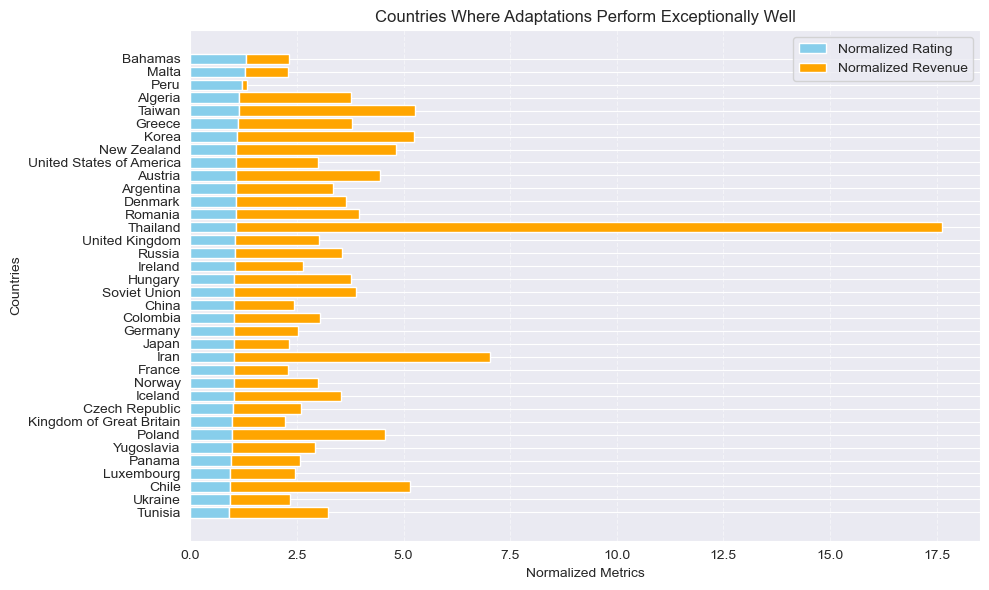

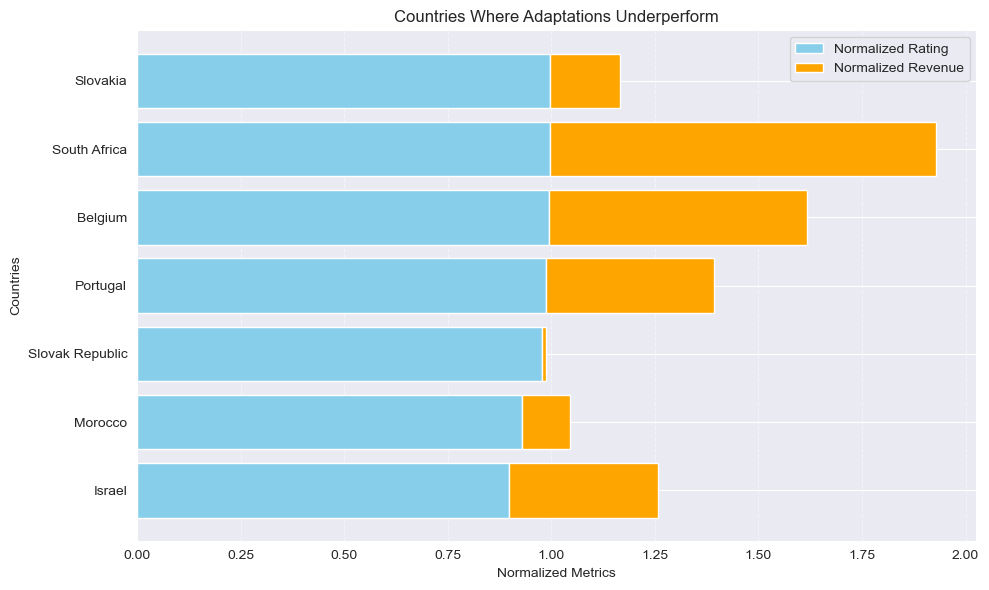

In [347]:
overperforming = normalized_data[(normalized_data['normalized_rating'] > 1.2) |
                                 (normalized_data['normalized_revenue'] > 1.2)]
underperforming = normalized_data[(normalized_data['normalized_rating'] < 1) &
                                  (normalized_data['normalized_revenue'] < 1)]

# Plot overperforming countries
fig, ax = plt.subplots(figsize=(10, 6))
overperforming_sorted = overperforming.sort_values(by='normalized_rating', ascending=True)
ax.barh(overperforming_sorted['movie_countries_clean'], overperforming_sorted['normalized_rating'],
        color='skyblue', label='Normalized Rating')
ax.barh(overperforming_sorted['movie_countries_clean'], overperforming_sorted['normalized_revenue'],
        left=overperforming_sorted['normalized_rating'], color='orange', label='Normalized Revenue')

ax.set_title('Countries Where Adaptations Perform Exceptionally Well')
ax.set_xlabel('Normalized Metrics')
ax.set_ylabel('Countries')
ax.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot underperforming countries
fig, ax = plt.subplots(figsize=(10, 6))
underperforming_sorted = underperforming.sort_values(by='normalized_rating', ascending=True)
ax.barh(underperforming_sorted['movie_countries_clean'], underperforming_sorted['normalized_rating'],
        color='skyblue', label='Normalized Rating')
ax.barh(underperforming_sorted['movie_countries_clean'], underperforming_sorted['normalized_revenue'],
        left=underperforming_sorted['normalized_rating'], color='orange', label='Normalized Revenue')

ax.set_title('Countries Where Adaptations Underperform')
ax.set_xlabel('Normalized Metrics')
ax.set_ylabel('Countries')
ax.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


To assess the international success of adaptations, we normalized ratings and revenues against the average performance of movies in each country.


Key Findings:
- High-Performing Regions: Countries like the Iran, Thailand, and Chile reveal outstanding commercial performance, where adaptations achieve revenues 4 to 17 times higher than their national averages. This suggests that adaptations in these regions may benefit from strong cultural appeal, established markets for book-to-screen content, and effective production investment.
- Underperforming Regions: Countries such as South Africa, Portugal, and Belgium show both normalized ratings and revenues below 1, indicating that adaptations struggle to gain audience approval or financial success. This may reflect limited market size, weaker adaptation quality, or cultural misalignment between source material and audiences.

Implications:
The results highlight significant regional disparities in adaptation success, suggesting that the commercial and critical outcomes are influenced by factors such as audience preferences, production budgets, and the ability to localize adaptations effectively.
High-performing regions may serve as favorable markets for future adaptations, while underperforming regions point to challenges in cultural resonance or market readiness for adaptations.
This analysis underscores the importance of understanding regional dynamics when evaluating the global reception of adaptations.

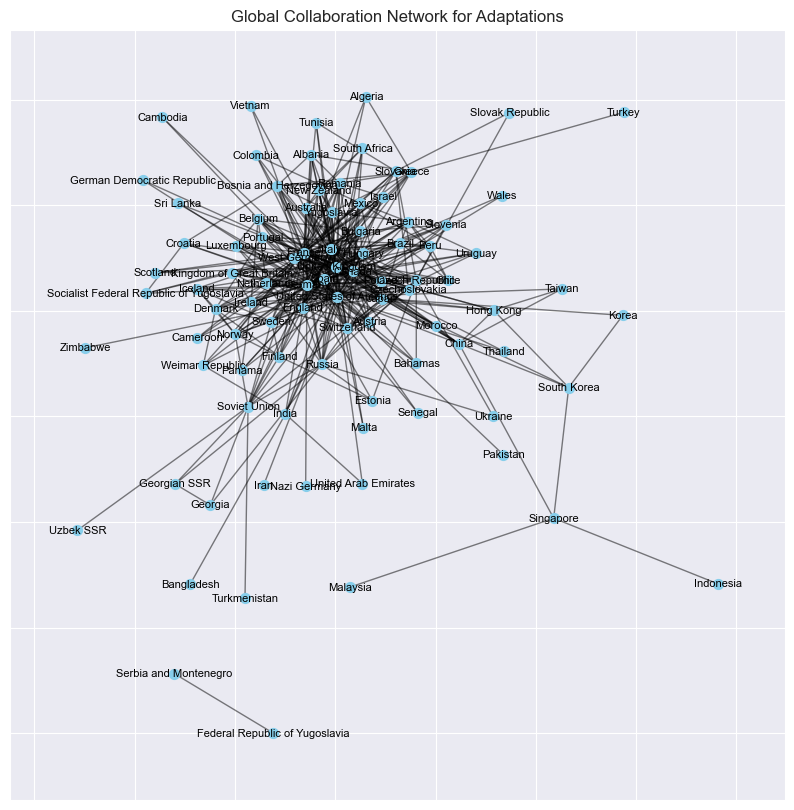

In [351]:
adaptations['country_pairs'] = adaptations['movie_countries_clean'].apply(create_country_pairs)
all_pairs = sum(adaptations['country_pairs'], [])

# Build a network graph
G = nx.Graph()
G.add_edges_from(all_pairs)

# Plot the network graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Global Collaboration Network for Adaptations')
plt.show()

In [354]:
# Count the frequency of country pairs
pair_counts = collections.Counter(all_pairs)

# Filter pairs with a minimum threshold (e.g., collaborations ≥ 5)
threshold = 5
filtered_pairs = [pair for pair, count in pair_counts.items() if count >= threshold]

# Build a reduced network graph
G_filtered = nx.Graph()
G_filtered.add_edges_from(filtered_pairs)

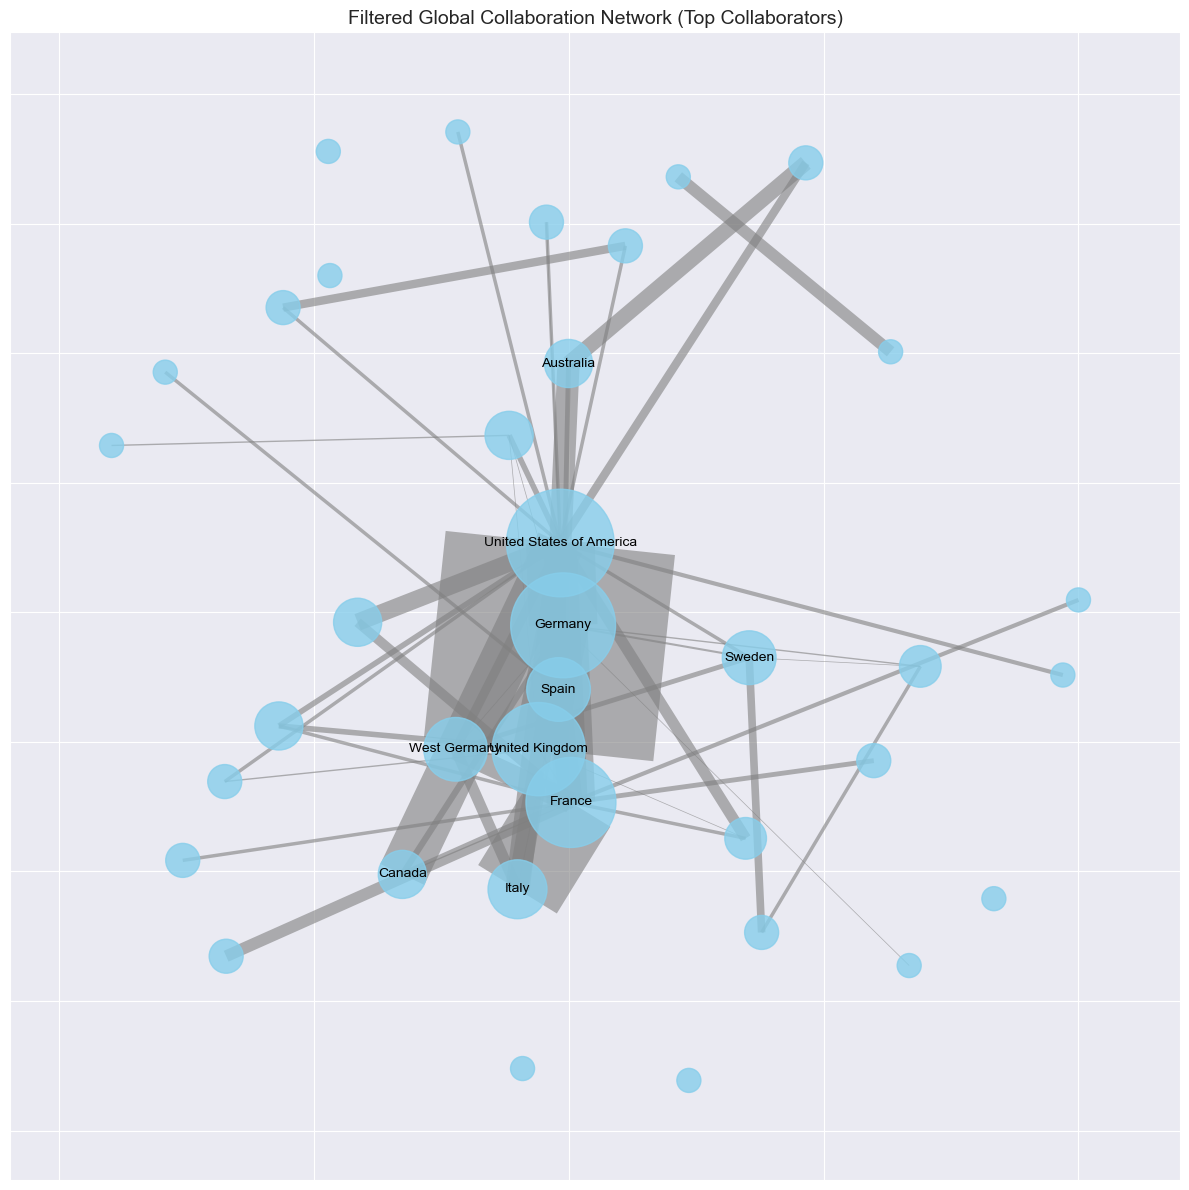

In [355]:
# Adjust layout for spacing
pos = nx.spring_layout(G_filtered, k=1.0, seed=42)

# Scale node sizes by degree
node_sizes = [degree * 300 for node, degree in dict(G_filtered.degree()).items()]

# Scale edge widths by collaboration strength
edge_widths = [pair_counts[edge] * 0.5 for edge in G_filtered.edges()]

# Select top 10 nodes for labeling
top_nodes = [node for node, degree in sorted(G_filtered.degree(), key=lambda x: x[1], reverse=True)[:10]]

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=edge_widths, alpha=0.6, edge_color='gray')

# Add labels for top nodes only
nx.draw_networkx_labels(G_filtered, pos, labels={n: n for n in top_nodes}, font_size=10, font_color='black')

# Add title
plt.title('Filtered Global Collaboration Network (Top Collaborators)', fontsize=14)
plt.tight_layout()
plt.show()

United States, Germany, France, Italy, and the United Kingdom are the most central and connected nodes.
These countries serve as the primary hubs for adaptation collaborations.
    Their larger node sizes indicate a higher degree (more connections), suggesting they are involved in the most partnerships.
Other notable hubs include Spain, Canada, and Australia, which also display substantial collaboration activity.

The success of adaptations may be influenced by the collaborative nature of production.
Countries like the United States, Germany, and the United Kingdom, with their strong ties and high centrality, likely benefit from shared resources, expertise, and access to larger markets.
The collaborative strength between specific regions (e.g., Europe and North America) highlights the dominance of these areas in the adaptation landscape.

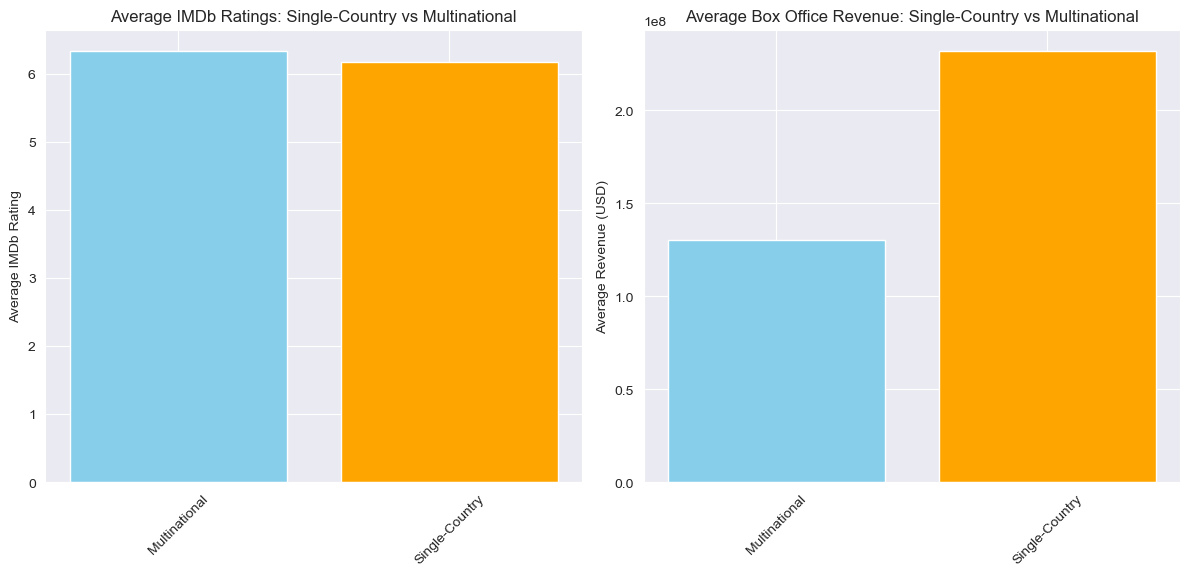

In [356]:
# Parse 'movie_countries' column safely
dataset['movie_countries_parsed'] = dataset['movie_countries'].apply(lambda x: ast.literal_eval(x))

# Categorize as collaborative or single-country
dataset['collaboration_type'] = dataset['movie_countries_parsed'].apply(
    lambda x: 'Multinational' if len(x) > 1 else 'Single-Country'
)

# Group by collaboration type and compute average metrics
collab_summary = dataset.groupby('collaboration_type').agg({
    'imdb_rating': 'mean',
    'movie_revenue': 'mean'
}).reset_index()

# Plot the results
plt.figure(figsize=(12, 6))

# Subplot 1: IMDb Ratings
plt.subplot(1, 2, 1)
plt.bar(collab_summary['collaboration_type'], collab_summary['imdb_rating'], color=['skyblue', 'orange'])
plt.title('Average IMDb Ratings: Single-Country vs Multinational')
plt.ylabel('Average IMDb Rating')
plt.xticks(rotation=45)

# Subplot 2: Revenues
plt.subplot(1, 2, 2)
plt.bar(collab_summary['collaboration_type'], collab_summary['movie_revenue'], color=['skyblue', 'orange'])
plt.title('Average Box Office Revenue: Single-Country vs Multinational')
plt.ylabel('Average Revenue (USD)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The results reveal an intriguing contrast: single-country adaptations achieve significantly higher average box office revenues, whereas multinational productions receive slightly higher IMDb ratings. This suggests that single-country adaptations may benefit from strong resonance with domestic audiences, leading to higher revenue concentrated within familiar cultural markets. In contrast, multinational collaborations likely leverage diverse resources, talent, and broader appeal, resulting in improved production quality and critical reception, reflected in their ratings. However, the imbalance raises questions about potential data bias or sample size differences, as well as missing revenue data for multinational productions that could skew results.


In [357]:
# Check Sample Size
sample_counts = dataset['collaboration_type'].value_counts()
print("Sample size for each group:")
print(sample_counts)

Sample size for each group:
collaboration_type
Single-Country    67568
Multinational      8976
Name: count, dtype: int64


the imbalance in sample size skews the observed results, making single-country adaptations appear more financially successful due to extreme outliers. To address this issue, we can downsample the single-country group to match the sample size of multinational adaptations. By creating balanced samples, we can fairly compare their performance.

/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_8096/1520682160.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/j1/j4l0ld1s6dz8kzf6ptph9n5w0000gn/T/ipykernel_8096/1520682160.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




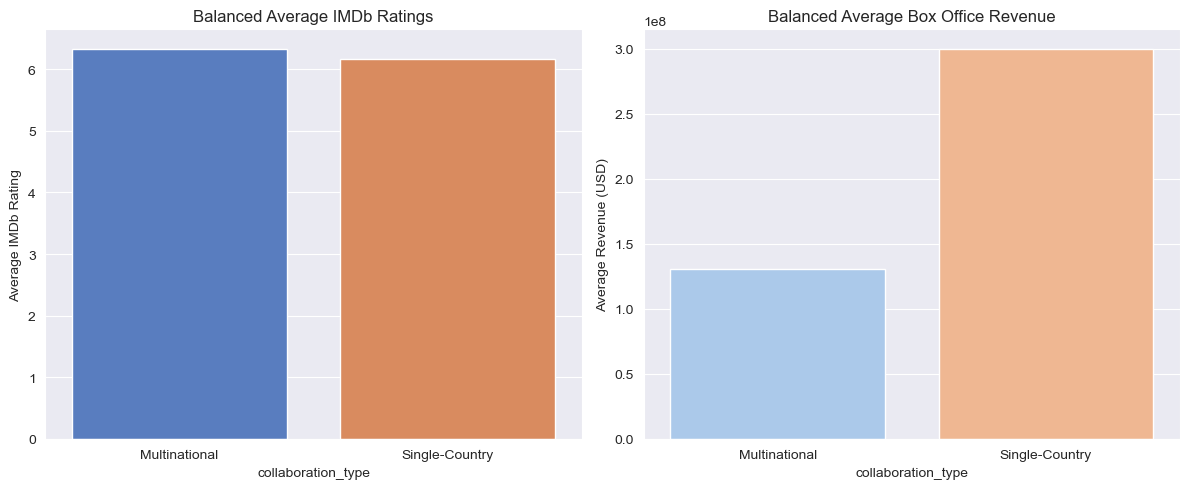

In [360]:
# Separate the data
single_country = dataset[dataset['collaboration_type'] == 'Single-Country']
multinational = dataset[dataset['collaboration_type'] == 'Multinational']

# Downsample single-country to match multinational size
single_country_balanced = resample(single_country,
                                   replace=False,
                                   n_samples=len(multinational),
                                   random_state=42)

# Combine the balanced datasets
balanced_dataset = pd.concat([single_country_balanced, multinational])

# Recalculate metrics
balanced_summary = balanced_dataset.groupby('collaboration_type').agg({
    'imdb_rating': 'mean',
    'movie_revenue': 'mean'
}).reset_index()

# Plot updated boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# IMDb Ratings Comparison
sns.barplot(data=balanced_summary, x='collaboration_type', y='imdb_rating',
            ax=axes[0], palette="muted", hue=None)  # Explicitly set hue=None
axes[0].set_title("Balanced Average IMDb Ratings")
axes[0].set_ylabel("Average IMDb Rating")

# Revenue Comparison
sns.barplot(data=balanced_summary, x='collaboration_type', y='movie_revenue',
            ax=axes[1], palette="pastel", hue=None)  # Explicitly set hue=None
axes[1].set_title("Balanced Average Box Office Revenue")
axes[1].set_ylabel("Average Revenue (USD)")

plt.tight_layout()
plt.show()


In [361]:
# Verify the sample size after balancing
print("Sample size after balancing:")
print(balanced_dataset['collaboration_type'].value_counts())

# Optionally display basic stats for validation
print("\nRevenue Summary (Post-Balancing and Outlier Removal):")
print(balanced_dataset.groupby('collaboration_type')['movie_revenue'].describe())

print("\nIMDb Rating Summary (Post-Balancing and Outlier Removal):")
print(balanced_dataset.groupby('collaboration_type')['imdb_rating'].describe())

Sample size after balancing:
collaboration_type
Single-Country    8976
Multinational     8976
Name: count, dtype: int64

Revenue Summary (Post-Balancing and Outlier Removal):
                     count          mean           std       min  \
collaboration_type                                                 
Multinational       2485.0  1.304695e+08  4.686739e+08  1.931753   
Single-Country      1031.0  2.998588e+08  3.517259e+09  4.481210   

                             25%           50%           75%           max  
collaboration_type                                                          
Multinational       3.255531e+06  2.392391e+07  1.047971e+08  1.365933e+10  
Single-Country      5.827821e+06  4.124158e+07  1.564476e+08  1.116667e+11  

IMDb Rating Summary (Post-Balancing and Outlier Removal):
                     count      mean       std  min  25%  50%  75%  max
collaboration_type                                                     
Multinational       8398.0  6.328340  1.0

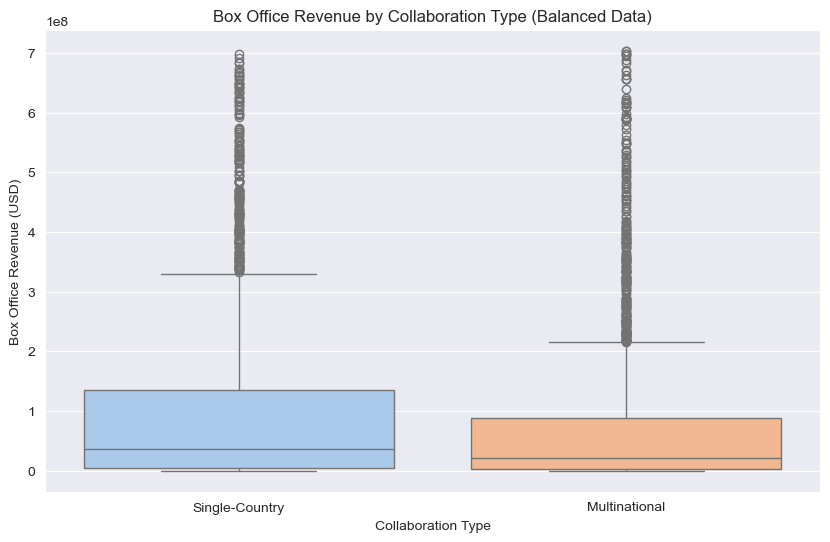

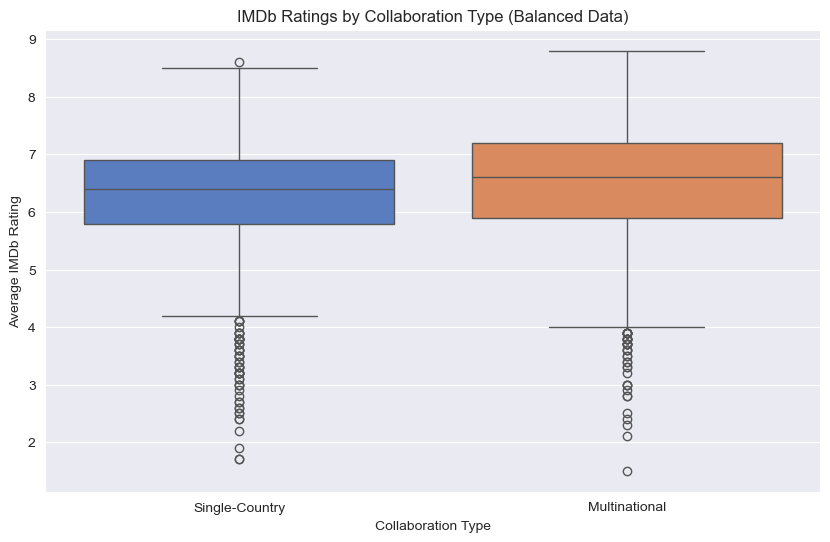

In [362]:
# Outlier Removal: Remove top 5% revenue earners
revenue_cutoff = dataset['movie_revenue'].quantile(0.95)
filtered_single = single_country[single_country['movie_revenue'] <= revenue_cutoff]
filtered_multi = multinational[multinational['movie_revenue'] <= revenue_cutoff]

# Balance the sample sizes
min_size = min(len(filtered_single), len(filtered_multi))
balanced_single = resample(filtered_single, replace=False, n_samples=min_size, random_state=42)
balanced_multi = resample(filtered_multi, replace=False, n_samples=min_size, random_state=42)

# Combine the balanced datasets
balanced_dataset = pd.concat([balanced_single, balanced_multi])

# Visualize Boxplots for Revenue and Ratings after balancing and outlier removal
# Box plot for movie revenue
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=balanced_dataset,
    x='collaboration_type',
    y='movie_revenue',
    hue='collaboration_type',
    palette='pastel',
    legend=False
)
plt.title('Box Office Revenue by Collaboration Type (Balanced Data)')
plt.xlabel('Collaboration Type')
plt.ylabel('Box Office Revenue (USD)')
plt.show()

# Box plot for IMDb ratings
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=balanced_dataset,
    x='collaboration_type',
    y='imdb_rating',
    hue='collaboration_type',
    palette='muted',
    legend=False
)
plt.title('IMDb Ratings by Collaboration Type (Balanced Data)')
plt.xlabel('Collaboration Type')
plt.ylabel('Average IMDb Rating')
plt.show()

Multinational adaptations excel in audience satisfaction (higher IMDb ratings), potentially due to diverse creative input and broader appeal across regions.
However, Single-Country adaptations tend to have higher revenue variability, with some achieving significant commercial success likely driven by localized appeal or niche markets. These findings suggest that while Multinational adaptations ensure consistent quality and global reception, Single-Country adaptations have the potential for higher financial extremes, both success and failure. This highlights the trade-off between stability and variability in adaptation success.
The results underscore the importance of considering audience reception and financial outcomes separately. Multinational adaptations may be better suited for achieving global audience satisfaction, while Single-Country adaptations, although riskier, offer opportunities for exceptional revenue performance. This nuanced view aligns with the research question by showing how collaboration type influences success metrics differently.